# NN with only Convolution Layers for 3 Track Events (find hit location)

In [1]:

# System imports
import math
from __future__ import print_function

# Standard imports
import sys
import numpy as np
from tempfile import TemporaryFile

# Python Externa Imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Keras Imports
from keras import models
from keras import layers
import keras.backend as K
from keras.regularizers import l2


# Local imports
from local_modules import generate_data, track_hit_coords, drawMulti_from_params_pix, draw_from_params, get_Alist_pulls

# Magic
%matplotlib inline

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:04:00.0)


In [2]:
#data = np.load('/bigdata/atsaris/train_data.npz')
data = np.load('/bigdata/atsaris/new/data6trk_256.npz')
#data = np.load('/home/atsaris/hepTrack_newY_test/23_04_2017/train_data_test.npz') # use it for test

In [3]:
# Model
def build_model_2():
    """Test model.  Consists of several convolutional layers followed by dense layers and an output layer"""
    input_layer = layers.Input(shape=(1, num_det_layers, det_layer_size, det_layer_size))
    layer = layers.Convolution3D(8, 3, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution3D(8, 3, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling3D(pool_size=(2,2,2))(layer)
    layer = layers.Convolution3D(16, 3, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution3D(16, 3, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(40)(layer)
    layer = layers.Dense((2*num_det_layers)*max_tracks)(layer)
    output_layer = layers.Reshape((max_tracks,(2*num_det_layers)))(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam', sample_weight_mode="temporal", metrics=['accuracy'])
    return model

Max_tracks:  6
Num_tracks:  3
epoch_size:  25600
num_epochs:  10

[[  9.7783325   17.48290031   9.89752791  16.2241946   10.01672333
   14.96548889  10.13591874  13.70678318  10.25511416  12.44807747
   10.37430957  11.18937176  10.49350498   9.93066605  10.6127004
    8.67196034  10.73189581   7.41325463  10.85109123   6.15454892]
 [ 22.40537671  14.918806    22.58778823  16.2753773   22.77019976
   17.6319486   22.95261129  18.9885199   23.13502282  20.34509121
   23.31743435  21.70166251  23.49984587  23.05823381  23.6822574
   24.41480511  23.86466893  25.77137641  24.04708046  27.12794772]
 [ 31.07697689  10.48709732  30.10432893  11.77453181  29.13168098
   13.06196629  28.15903303  14.34940078  27.18638507  15.63683526
   26.21373712  16.92426975  25.24108917  18.21170424  24.26844121
   19.49913872  23.29579326  20.78657321  22.32314531  22.07400769]
 [-99.         -99.         -99.         -99.         -99.         -99.
  -99.         -99.         -99.         -99.         -99

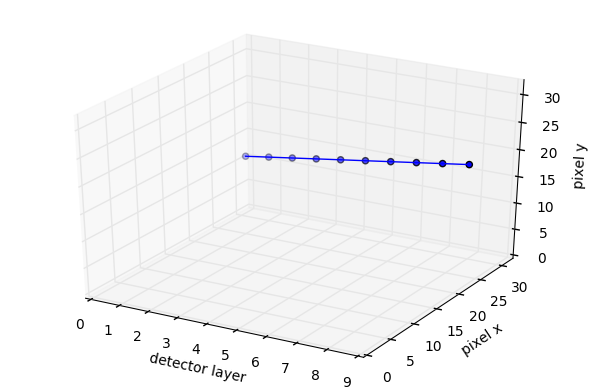

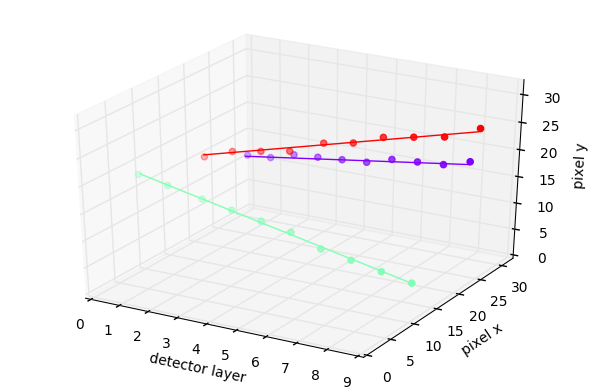

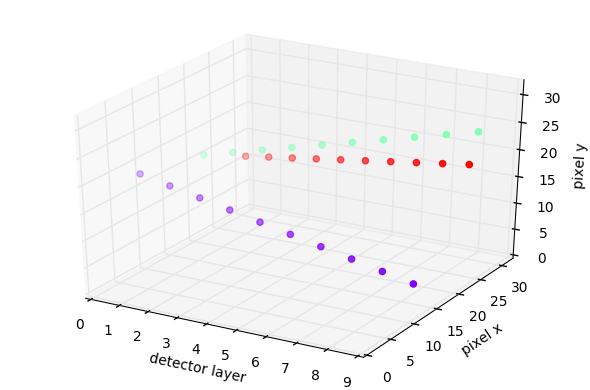

In [4]:
# Configuration
num_det_layers = data['num_det_layers']
det_layer_size = data['det_layer_size']
num_seed_layers = 0
avg_bkg_tracks = 0
noise_prob = 0.0
det_shape = (num_det_layers, det_layer_size, det_layer_size)

max_tracks = data['max_tracks']
num_tracks = data['num_tracks']

# Training parameters
batch_size = data['batch_size']
epoch_size = data['epoch_size']
num_epochs = data['num_epochs']

print("Max_tracks: ", max_tracks)
print("Num_tracks: ", num_tracks)
print("epoch_size: ", epoch_size)
print("num_epochs: ", num_epochs)

events = data['events']
targets_par = data['target_slope']
targets_pix = data['target_slope_pix']
weights = data['weights']

# Make sure input to NN is OK
test_index = np.random.randint(epoch_size)
test_event = events[test_index]
test_target_par = targets_par[test_index]
test_target_pix = targets_pix[test_index]
print("")
#print(test_event, "\n")
print(test_target_pix, "\n")
print(test_target_par)
draw_from_params(test_target_par, num_det_layers, det_layer_size)
drawMulti_from_params_pix(num_tracks, test_target_par, num_det_layers, det_layer_size, True)
drawMulti_from_params_pix(num_tracks, test_target_pix, num_det_layers, det_layer_size)

In [5]:
# Train the model
model_2 = build_model_2()
history = model_2.fit(events, targets_pix, batch_size=batch_size, nb_epoch=num_epochs, 
           validation_split=0.1, sample_weight=weights)

Train on 23040 samples, validate on 2560 samples
Epoch 1/10
23040/23040 [==============================] - 22s - loss: 81.3327 - acc: 0.0937 - val_loss: 40.1247 - val_acc: 0.0970
Epoch 2/10
23040/23040 [==============================] - 26s - loss: 35.5355 - acc: 0.0964 - val_loss: 32.2289 - val_acc: 0.1109
Epoch 3/10
23040/23040 [==============================] - 31s - loss: 30.2065 - acc: 0.1426 - val_loss: 28.6487 - val_acc: 0.1788
Epoch 4/10
23040/23040 [==============================] - 32s - loss: 27.5742 - acc: 0.2059 - val_loss: 26.7879 - val_acc: 0.2243
Epoch 5/10
23040/23040 [==============================] - 32s - loss: 26.2320 - acc: 0.2378 - val_loss: 25.7583 - val_acc: 0.2420
Epoch 6/10
23040/23040 [==============================] - 32s - loss: 25.1005 - acc: 0.2496 - val_loss: 24.6484 - val_acc: 0.2360
Epoch 7/10
23040/23040 [==============================] - 32s - loss: 23.8142 - acc: 0.2552 - val_loss: 23.4750 - val_acc: 0.2403
Epoch 8/10
23040/23040 [=================

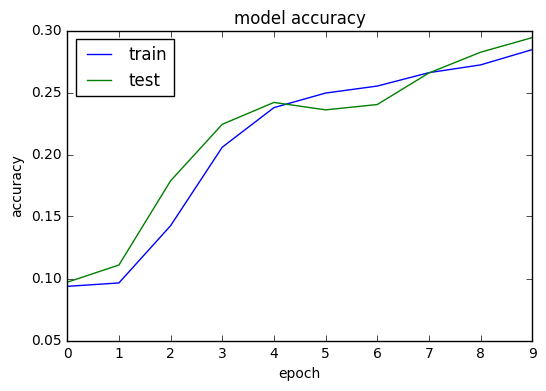

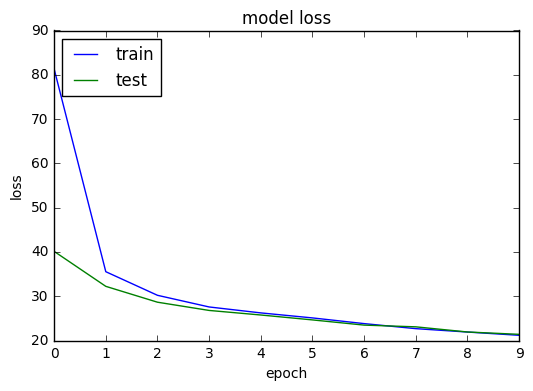

In [6]:
# Plot the accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
test_data = np.load('/bigdata/atsaris/new/test6trk_256.npz')
train_events = test_data['events']
train_targets_slope = test_data['target_slope']
train_targets_slope_pix = test_data['target_slope_pix']
train_weights = test_data['weights']

In [8]:
for i in range(0, 2*num_det_layers):
    mu, sigma = get_Alist_pulls(model_2, 1000, train_events, train_weights, train_targets_slope_pix, i, False)
    print("pixel: ", mu, sigma)

pixel:  0.0492131133975 3.03904869764
pixel:  -0.0576919747366 5.92865920006
pixel:  0.206860897556 2.71940662622
pixel:  -0.32461996062 5.29483501466
pixel:  0.111375497029 2.61047315737
pixel:  -0.0845250763692 4.77503638546
pixel:  0.0450018985268 2.73684533464
pixel:  -0.166012749894 4.38860740045
pixel:  0.137393288347 3.11105602017
pixel:  -0.0301966931228 4.26725781477
pixel:  0.149671592358 3.60616471789
pixel:  -0.319622757598 4.30427010456
pixel:  -0.0548341246416 4.24571091016
pixel:  -0.159564452314 4.56155825915
pixel:  -0.0442667775908 4.78519782202
pixel:  -0.121783491518 5.04813408214
pixel:  -0.118740784935 5.49704057087
pixel:  0.139727875455 5.63825912825
pixel:  -0.266143545649 6.22361121376
pixel:  -0.0609672767196 6.33291114327


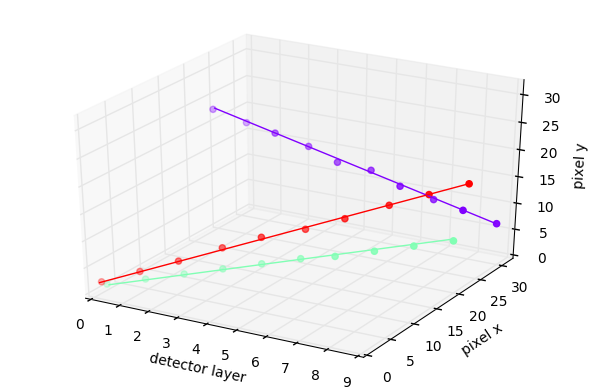

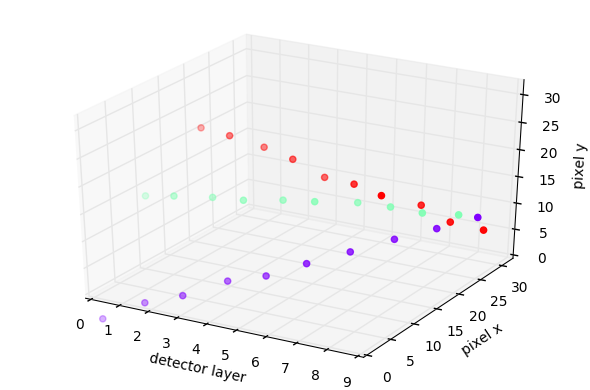

In [9]:
test_index = np.random.randint(0,test_data['epoch_size'])
# Draw Truth
test_weights = train_weights[test_index].astype(np.bool_)
test_a_tmp = train_targets_slope_pix[test_index][test_weights]
test_a = train_targets_slope[test_index][test_weights]
drawMulti_from_params_pix(num_tracks, test_a, num_det_layers, det_layer_size, True)
#drawMulti_from_params_pix(num_tracks, test_a_tmp, num_det_layers, det_layer_size)

# Draw Prediction
test_event = train_events[test_index]
test_pred = model_2.predict(np.asarray([test_event]))[0][test_weights]
drawMulti_from_params_pix(num_tracks, test_pred, num_det_layers, det_layer_size)